In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from scipy.special import boxcox1p
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.visualization import plot_optimization_history

c:\Users\keith\implementations\MachineLearning_AI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_DIR = Path.cwd()
DATASET_DIR = BASE_DIR.parent / "dataset"
TRAIN_PATH = DATASET_DIR / "train.csv"
TEST_PATH = DATASET_DIR / "test.csv"

In [3]:
kaggle_house_data = pd.read_csv(TRAIN_PATH)

# Exploring Data

In [4]:
kaggle_house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
kaggle_house_data["YrSold"].unique()

array([2008, 2007, 2006, 2009, 2010])

In [6]:
kaggle_house_data.shape

(1460, 81)

In [7]:
kaggle_house_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
kaggle_house_data.info()

<class 'pandas.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   str    
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   str    
 6   Alley          91 non-null     str    
 7   LotShape       1460 non-null   str    
 8   LandContour    1460 non-null   str    
 9   Utilities      1460 non-null   str    
 10  LotConfig      1460 non-null   str    
 11  LandSlope      1460 non-null   str    
 12  Neighborhood   1460 non-null   str    
 13  Condition1     1460 non-null   str    
 14  Condition2     1460 non-null   str    
 15  BldgType       1460 non-null   str    
 16  HouseStyle     1460 non-null   str    
 17  OverallQual    1460 non-null   int64  
 18  OverallCond    1460

In [9]:
kaggle_house_data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460.0,NaN,NaN,NaN,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,NaN,NaN,NaN,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201.0,NaN,NaN,NaN,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,NaN,NaN,NaN,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1460.0,NaN,NaN,NaN,6.321918,2.703626,1.0,5.0,6.0,8.0,12.0
YrSold,1460.0,NaN,NaN,NaN,2007.815753,1.328095,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1460,9,WD,1267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1460,6,Normal,1198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
missing = kaggle_house_data.isna().mean().sort_values(ascending=False)
missing[missing > 0]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
MasVnrType      0.597260
FireplaceQu     0.472603
LotFrontage     0.177397
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtCond        0.025342
BsmtQual        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
Electrical      0.000685
dtype: float64

In [11]:
# Missing values analysis
len(missing[missing>0])

19

In [12]:
#PoolQC has highest nan values
kaggle_house_data["PoolQC"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1455    NaN
1456    NaN
1457    NaN
1458    NaN
1459    NaN
Name: PoolQC, Length: 1460, dtype: str

<Axes: >

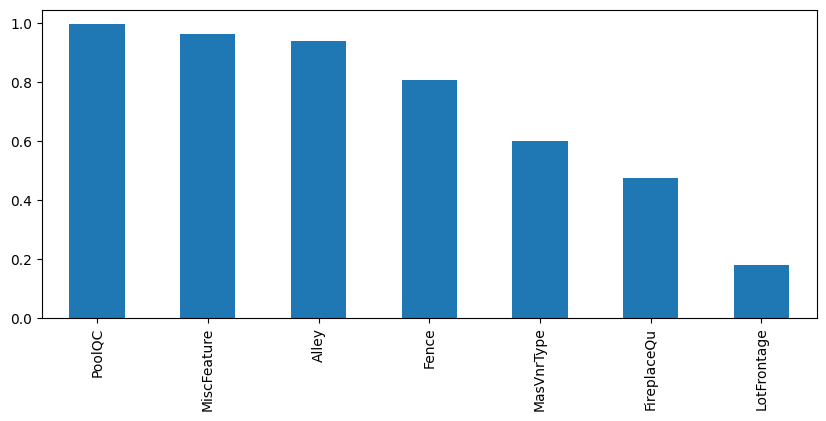

In [13]:
missing[missing > 0.1].plot(kind="bar", figsize=(10,4))

In [14]:
#Drop Id column here.
kaggle_house_df = kaggle_house_data.drop("Id", axis=1)

In [15]:
kaggle_house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
numeric_features = kaggle_house_df.select_dtypes(include=['number']).columns.tolist()
categorical_features = kaggle_house_df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

print(f"We have {len(numeric_features)} numerical features: {numeric_features}")
print(f"\nWe have {len(categorical_features)} categorical features: {categorical_features}")

We have 37 numerical features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

We have 43 categorical features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Func

Futher investigation we have 37 numerical features and 43 categorical features

In [17]:
pd.set_option('display.max_rows', None)

nulls = kaggle_house_df.isnull().sum()
print(nulls)

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

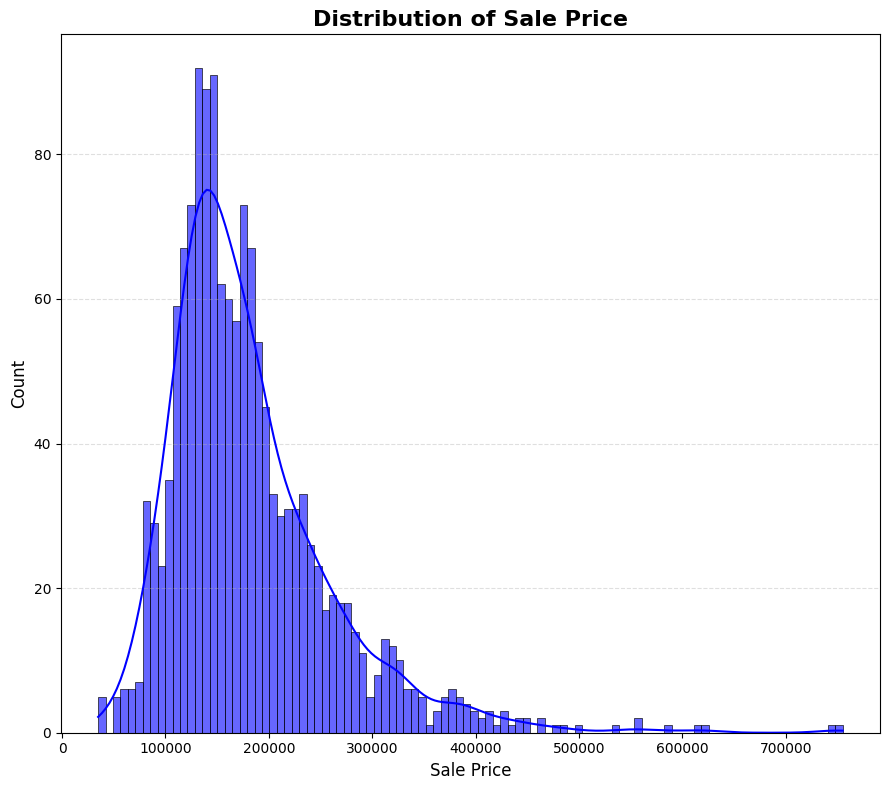

In [18]:
#Sale Price Distrbution.

plt.figure(figsize=(9, 8))

sns.histplot(
    kaggle_house_df['SalePrice'],
    bins=100,
    kde=True,
    color='blue',
    alpha=0.6
)

plt.title("Distribution of Sale Price", fontsize=16, weight="bold")
plt.xlabel("Sale Price", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [19]:
kaggle_house_df["PoolQC"].value_counts(dropna= False)

PoolQC
NaN    1453
Gd        3
Ex        2
Fa        2
Name: count, dtype: int64

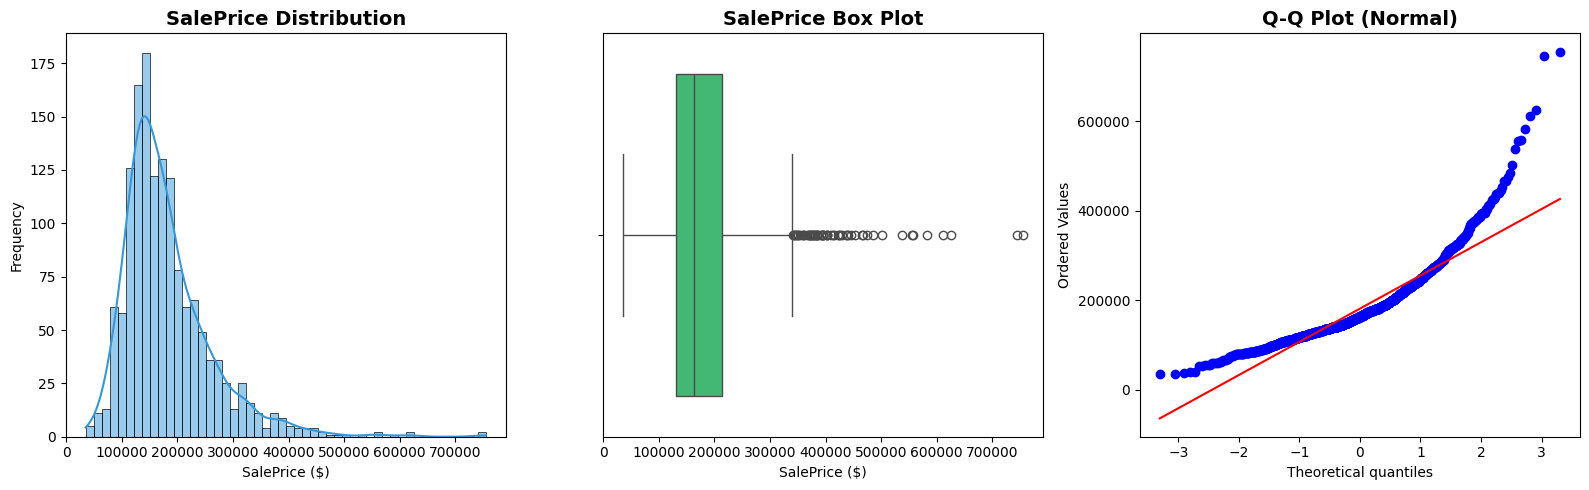

📈 Skewness: 1.8829
📈 Kurtosis: 6.5363

⚠️ The distribution is right-skewed - log transformation recommended.


In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Histogram with KDE
sns.histplot(kaggle_house_data['SalePrice'], kde=True, ax=axes[0], color='#3498db', bins=50)
axes[0].set_title('SalePrice Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('SalePrice ($)')
axes[0].set_ylabel('Frequency')

# Box plot
sns.boxplot(x=kaggle_house_data['SalePrice'], ax=axes[1], color='#2ecc71')
axes[1].set_title('SalePrice Box Plot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('SalePrice ($)')

# Q-Q Plot
stats.probplot(kaggle_house_data['SalePrice'], plot=axes[2])
axes[2].set_title('Q-Q Plot (Normal)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistics
print(f'📈 Skewness: {kaggle_house_data["SalePrice"].skew():.4f}')
print(f'📈 Kurtosis: {kaggle_house_data["SalePrice"].kurtosis():.4f}')
print('\n⚠️ The distribution is right-skewed - log transformation recommended.')

The dependent feature 'SalePrice' is right-skewed, we will have to perform a log-normal transformation on this feature.

In [21]:
kaggle_house_df_test = pd.read_csv(TEST_PATH).drop(columns=["Id"])

In [22]:
# Combine datasets for consistent preprocessing
ntrain = kaggle_house_df.shape[0]
ntest = kaggle_house_df_test.shape[0]
y_train = kaggle_house_df['SalePrice'].values

all_data = pd.concat([kaggle_house_df.drop('SalePrice', axis=1), kaggle_house_df_test], axis=0, ignore_index=True)
print(f'Combined data shape: {all_data.shape}')

# Calculate missing values
missing = all_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = (missing / len(all_data)) * 100

# Display missing values
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct.round(2)
})
print(f'\n🔍 Features with missing values: {len(missing_df)}')
missing_df.head(15)

Combined data shape: (2919, 79)

🔍 Features with missing values: 34


,Missing Count,Missing %
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
MasVnrType,1766,60.50
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageQual,159,5.45
GarageYrBlt,159,5.45
GarageCond,159,5.45


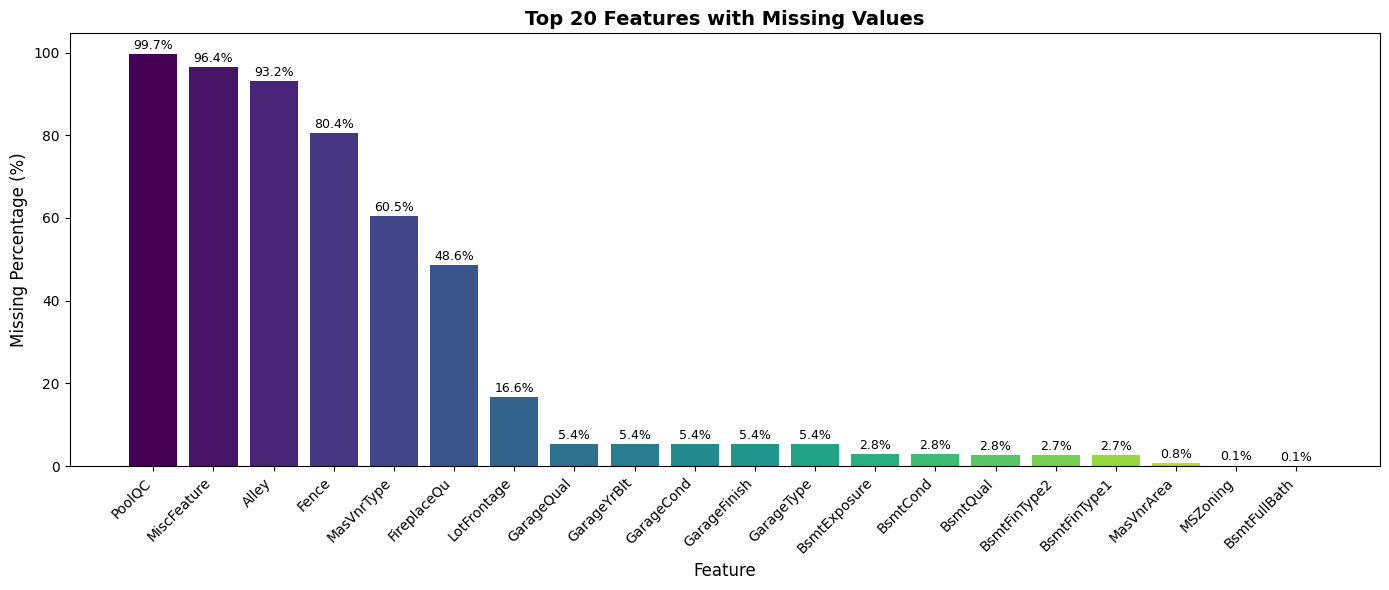

In [23]:
# Visualize missing values
plt.figure(figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(missing_pct.head(20))))
bars = plt.bar(missing_pct.head(20).index, missing_pct.head(20).values, color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.title('Top 20 Features with Missing Values', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, missing_pct.head(20).values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [24]:
# Correlation with SalePrice
numeric_train = kaggle_house_df.select_dtypes(include=[np.number])
correlations = numeric_train.corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False)

# Interactive bar chart
fig = px.bar(
    x=correlations.values,
    y=correlations.index,
    orientation='h',
    title='Feature Correlation with SalePrice',
    labels={'x': 'Correlation', 'y': 'Feature'},
    color=correlations.values,
    color_continuous_scale='RdYlGn'
)
fig.update_layout(height=800, showlegend=False)
fig.show()
fig.show(renderer='iframe')

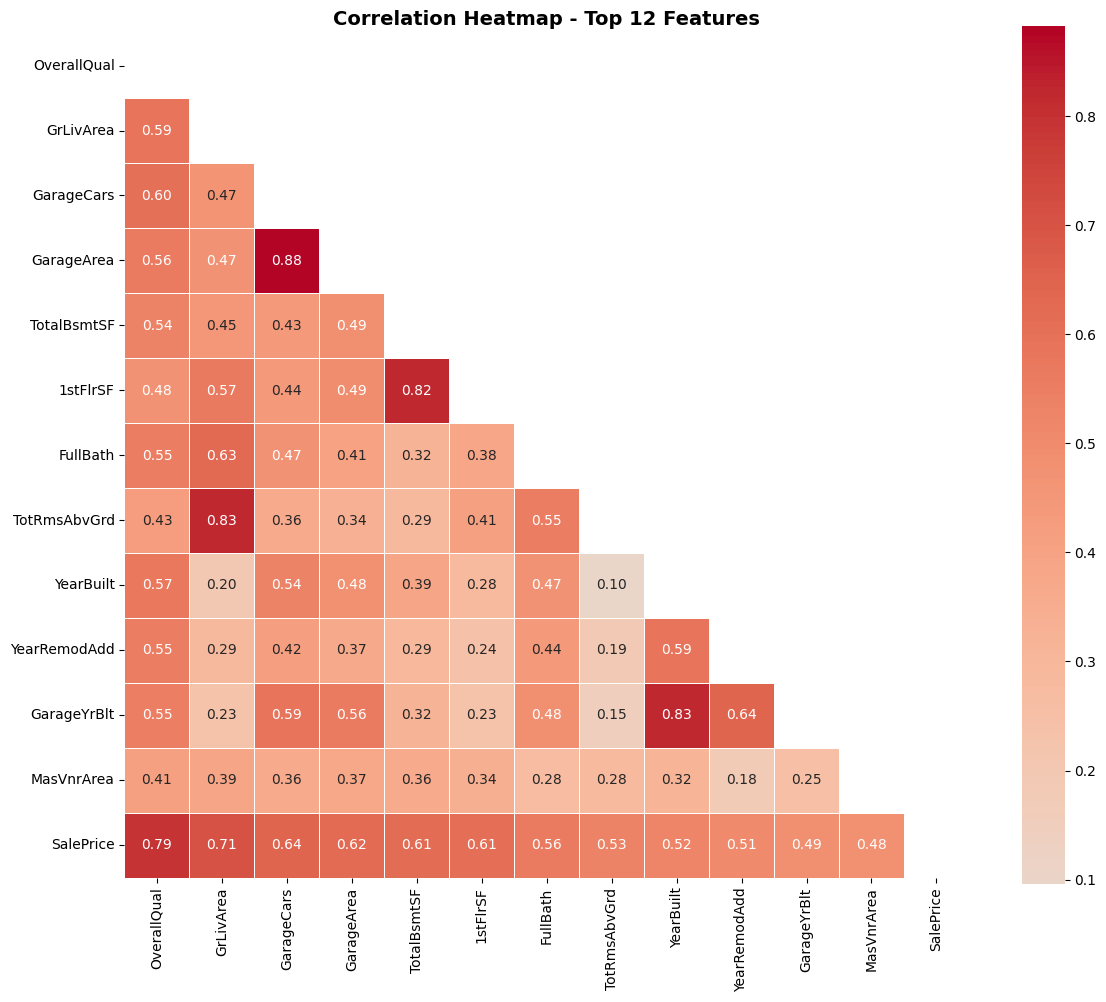

In [25]:
# Top features correlation heatmap
top_features = correlations.abs().sort_values(ascending=False).head(12).index.tolist()
top_features.append('SalePrice')

plt.figure(figsize=(12, 10))
corr_matrix = kaggle_house_df[top_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, linewidths=0.5,
            annot_kws={'size': 10}, square=True)
plt.title('Correlation Heatmap - Top 12 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Univariate Analysis
The term univariate analysis refers to the analysis of one variable prefix “uni” means “one.” The purpose of univariate analysis is to understand the distribution of values for a single variable.
Other Type of Analysis are

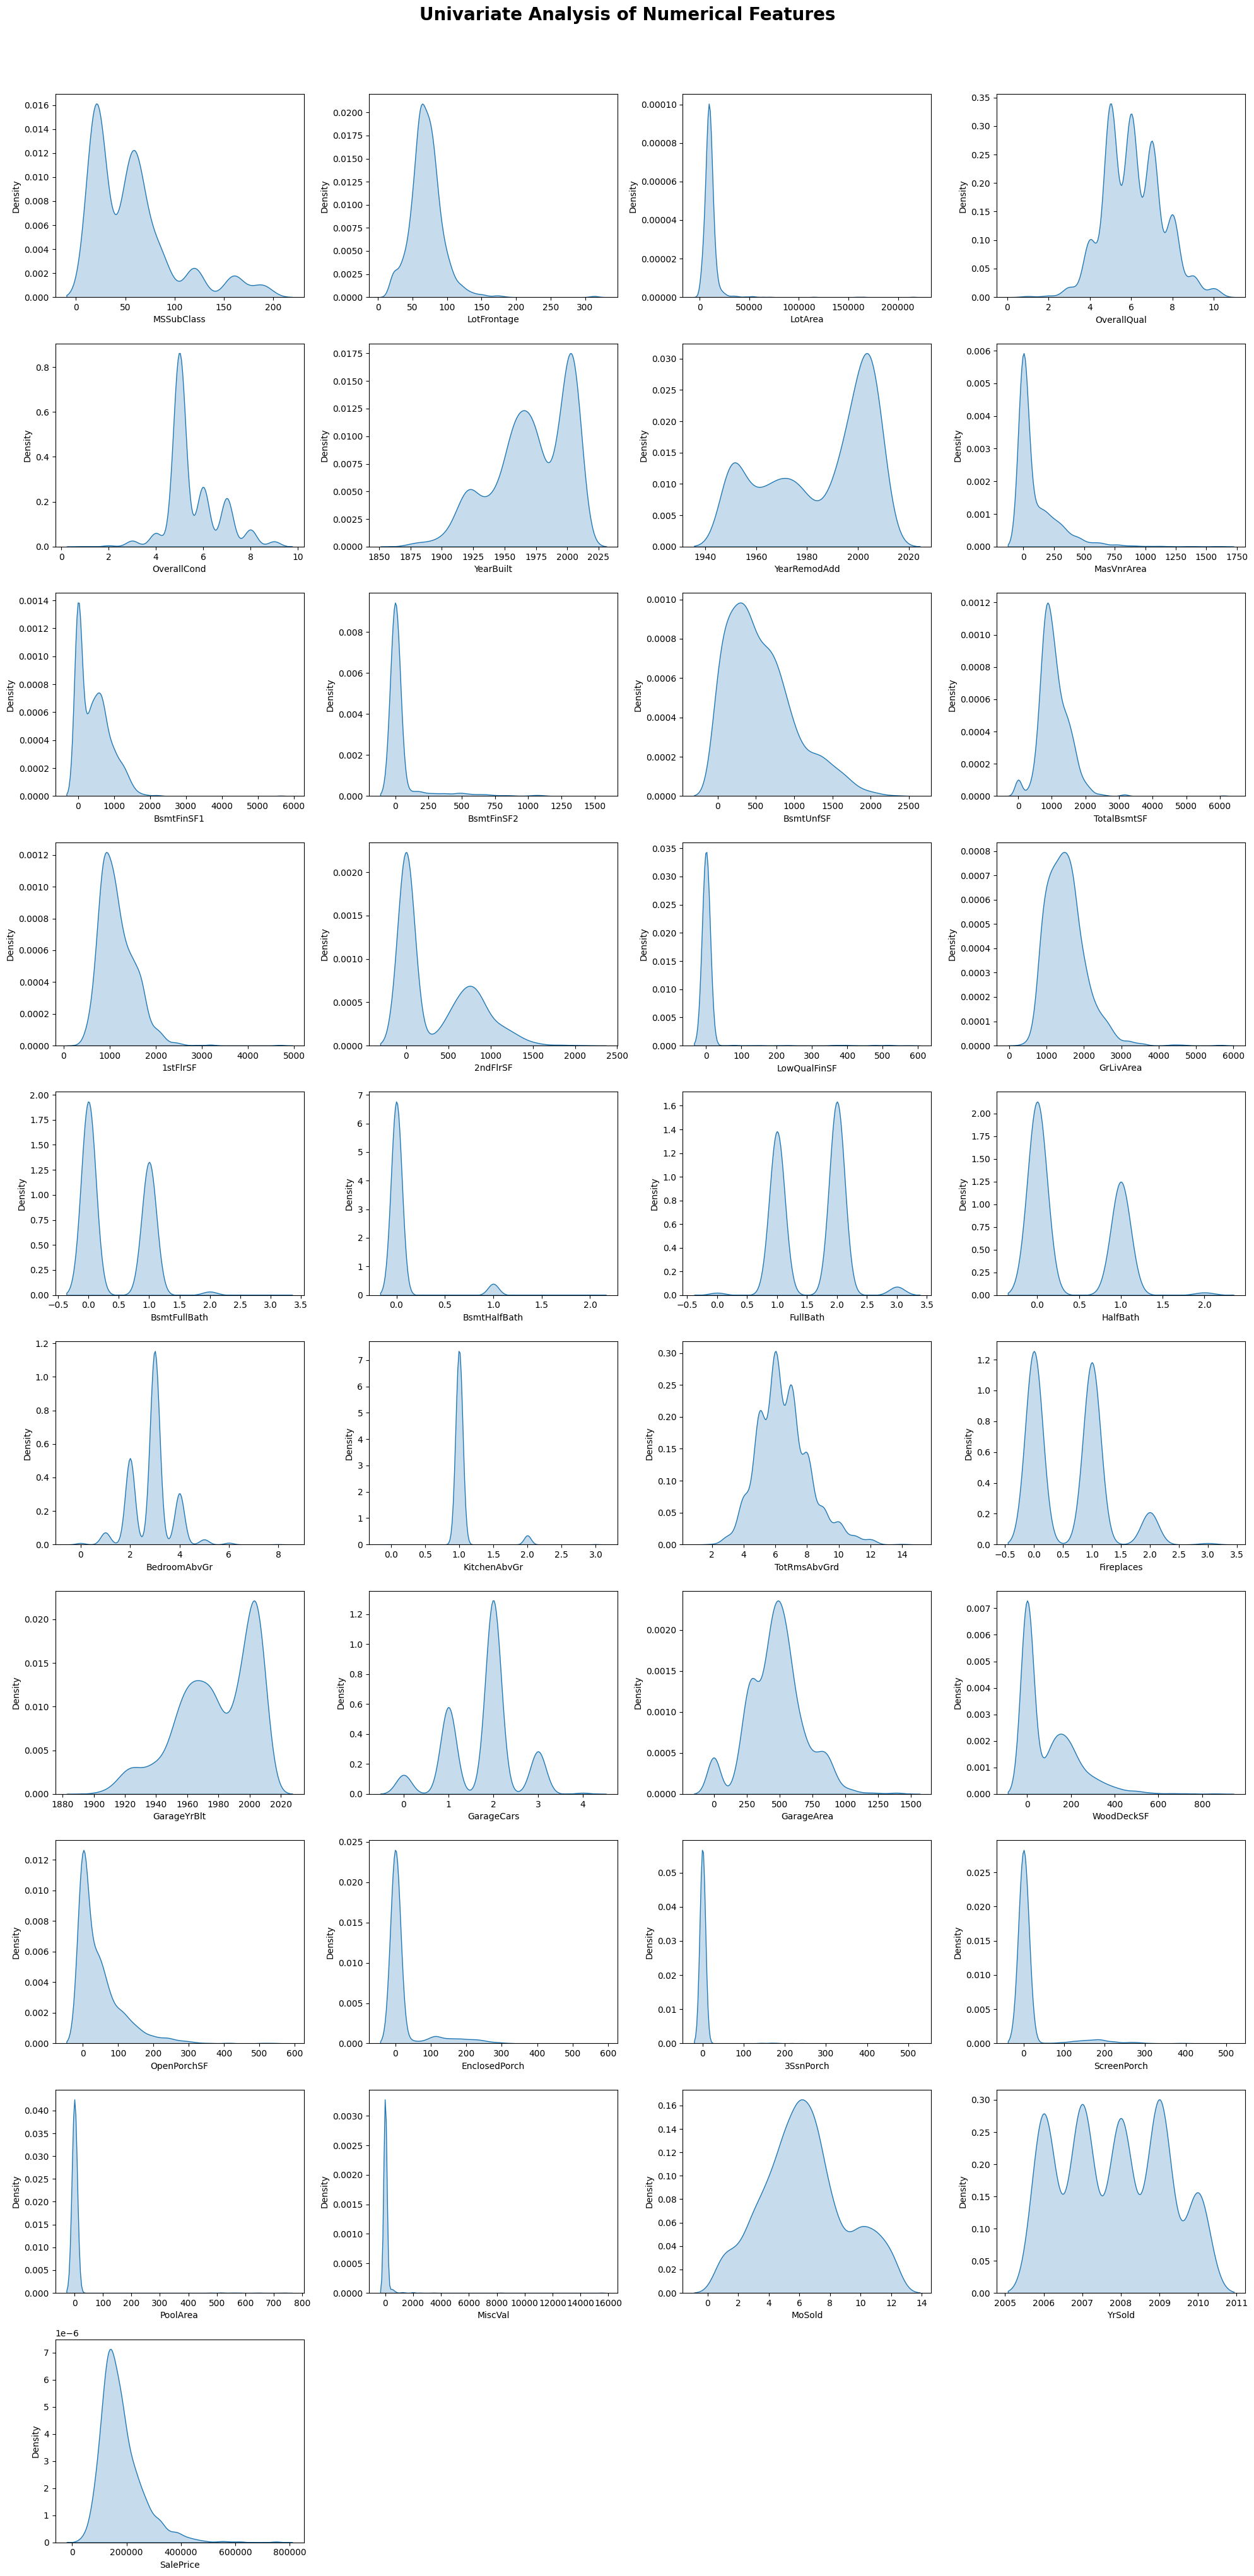

In [26]:
import math
n_features = len(numeric_features)
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

plt.figure(figsize=(20, n_rows * 4))
plt.suptitle(
    'Univariate Analysis of Numerical Features',
    fontsize=20,
    fontweight='bold',
    y=1.02
)

for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(kaggle_house_df[feature].dropna(), fill=True)
    plt.xlabel(feature)
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

In [27]:
len(categorical_features)

43

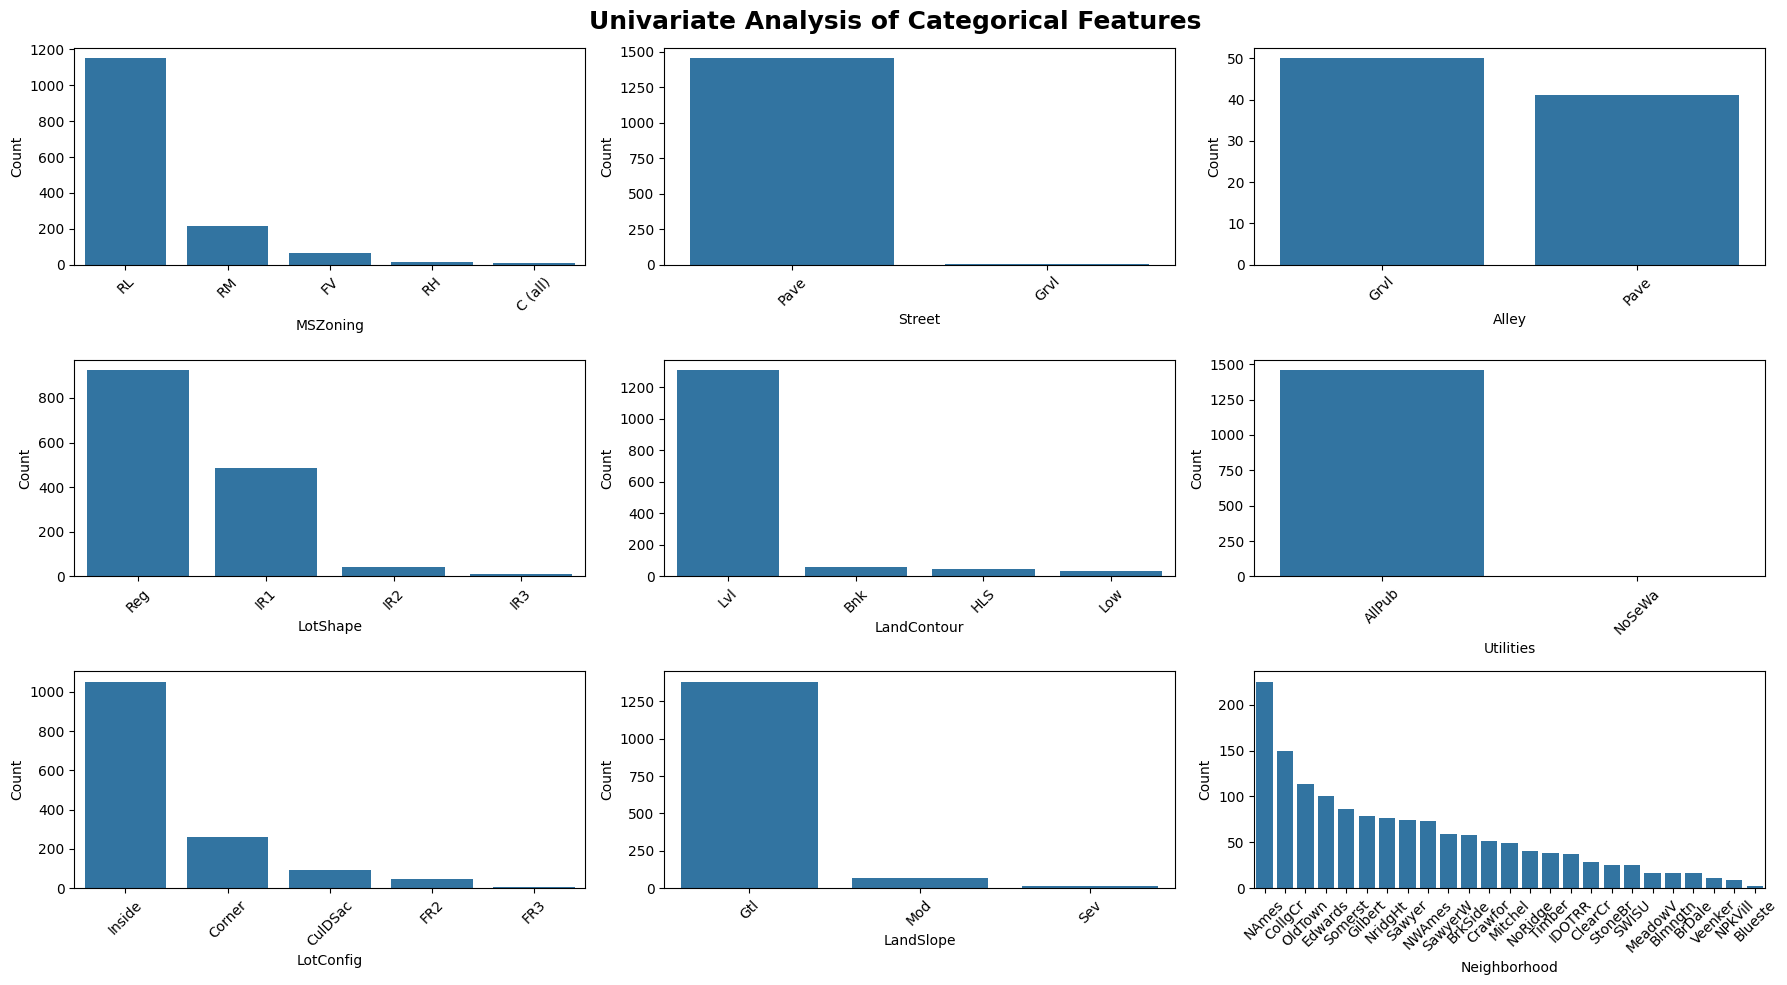

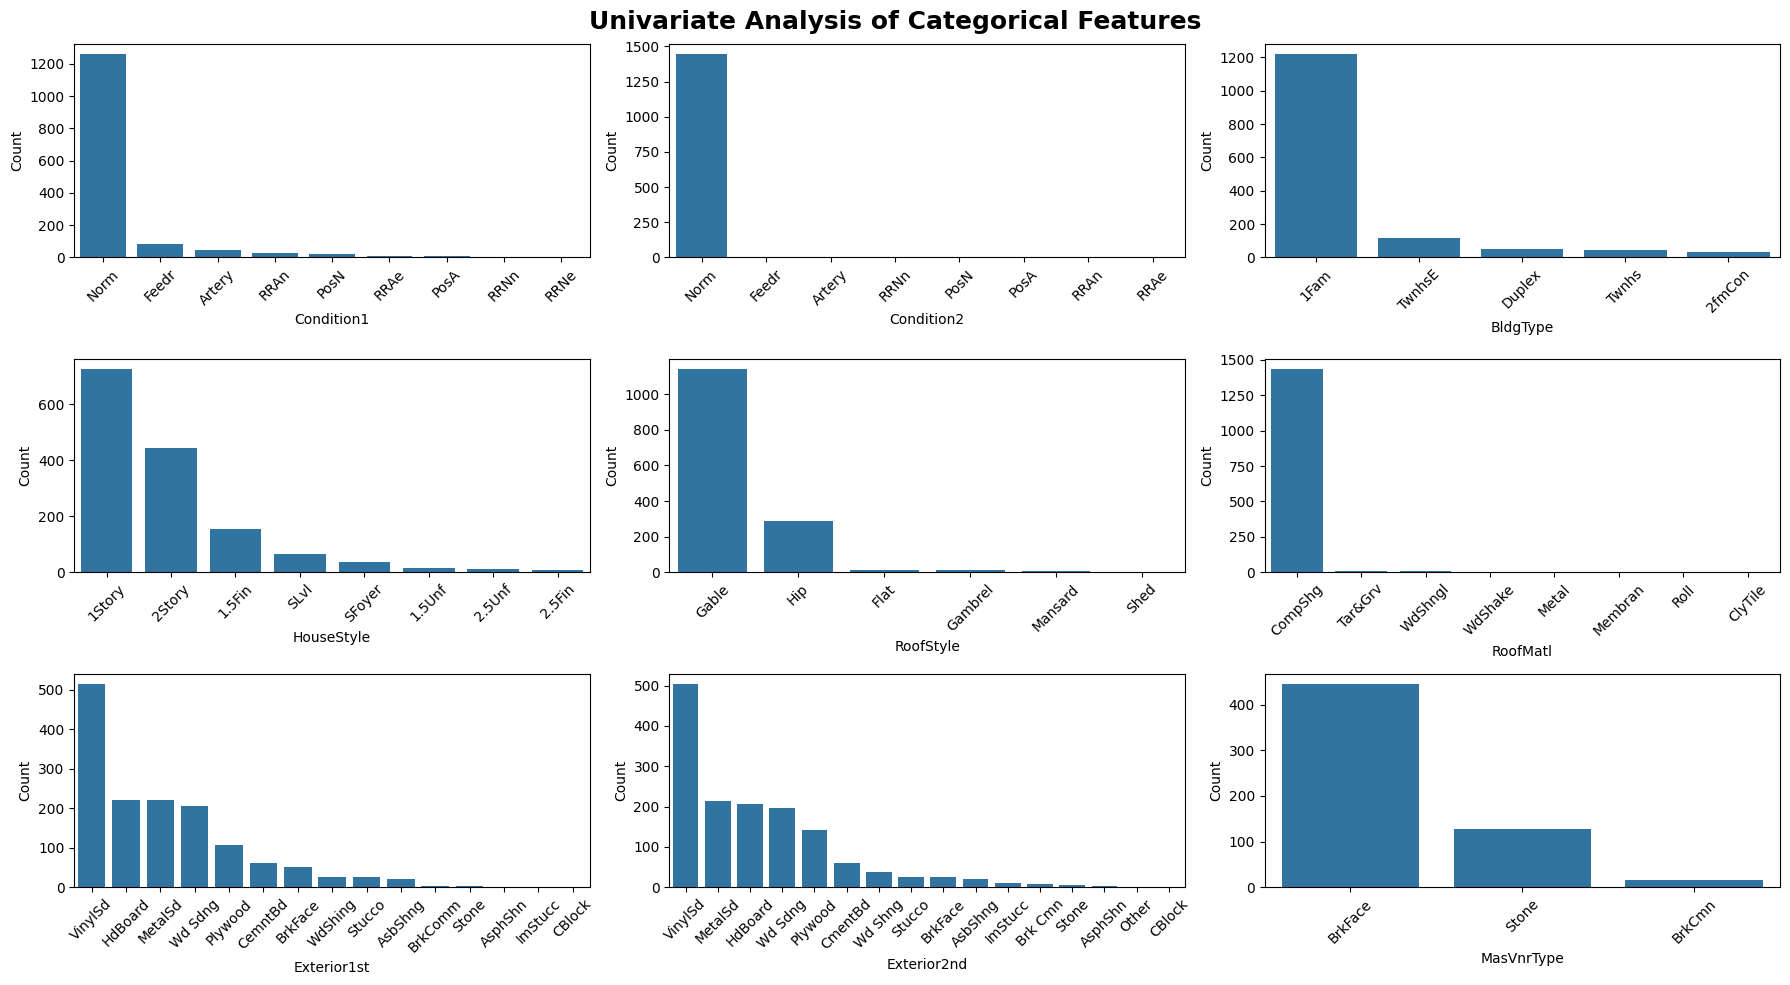

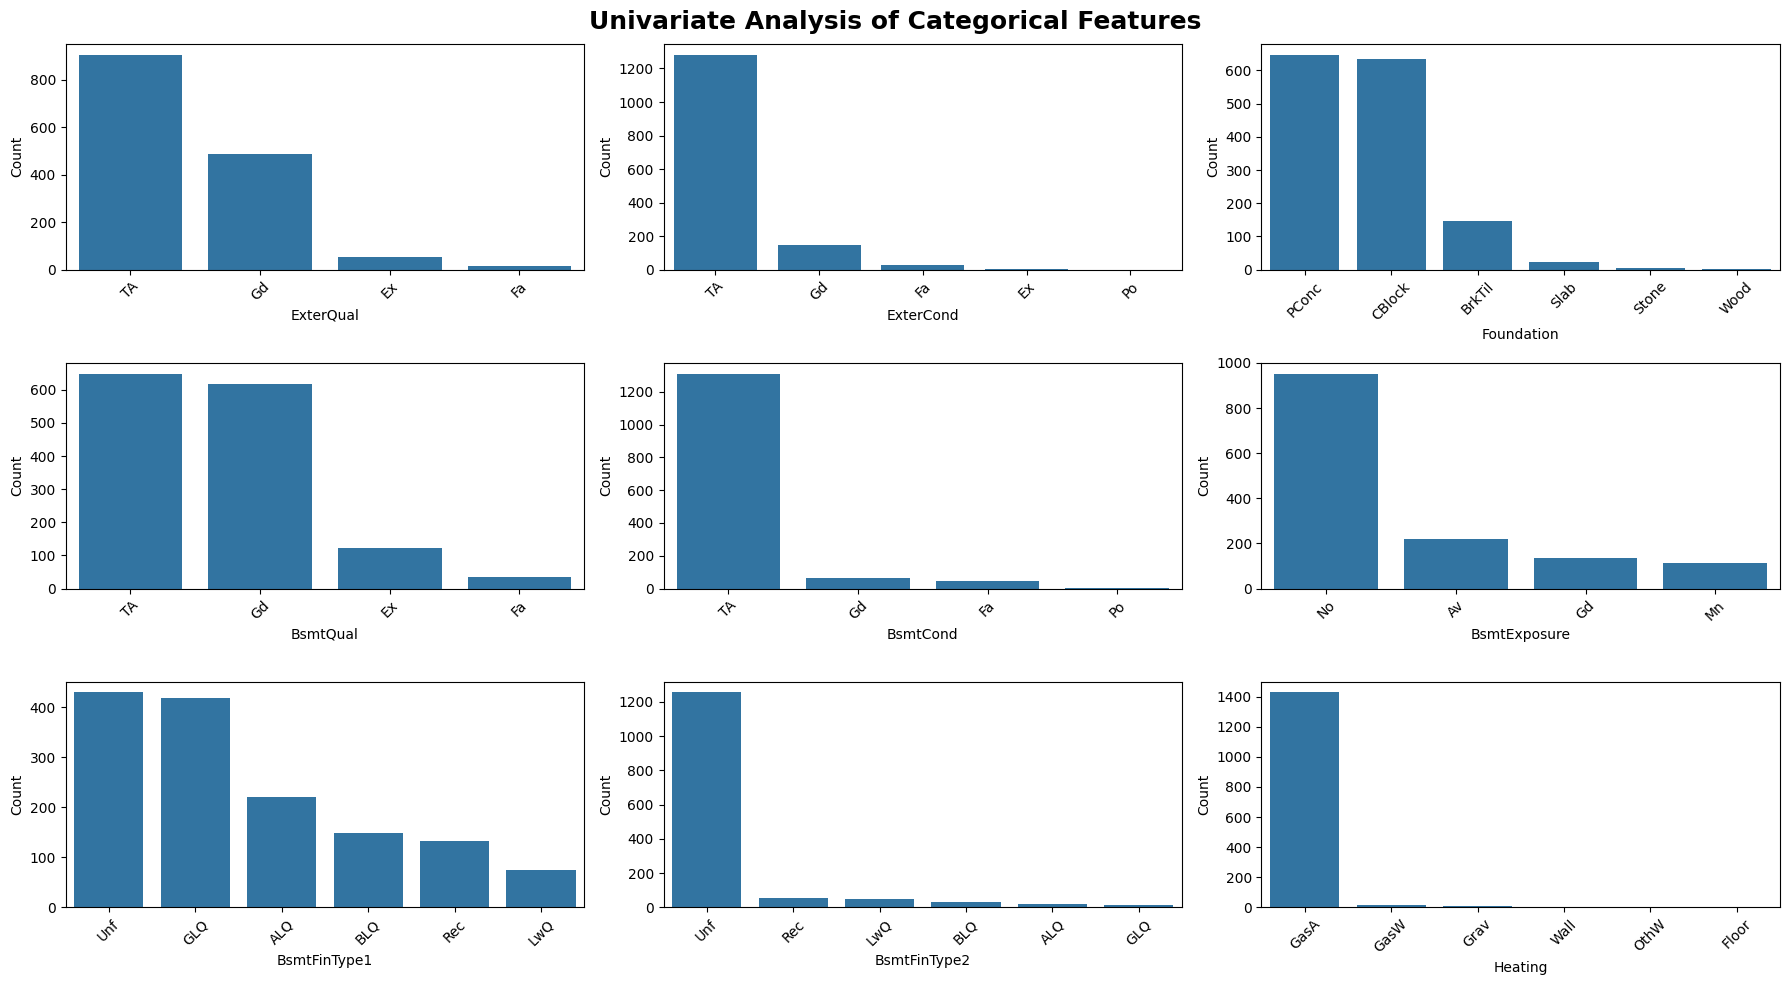

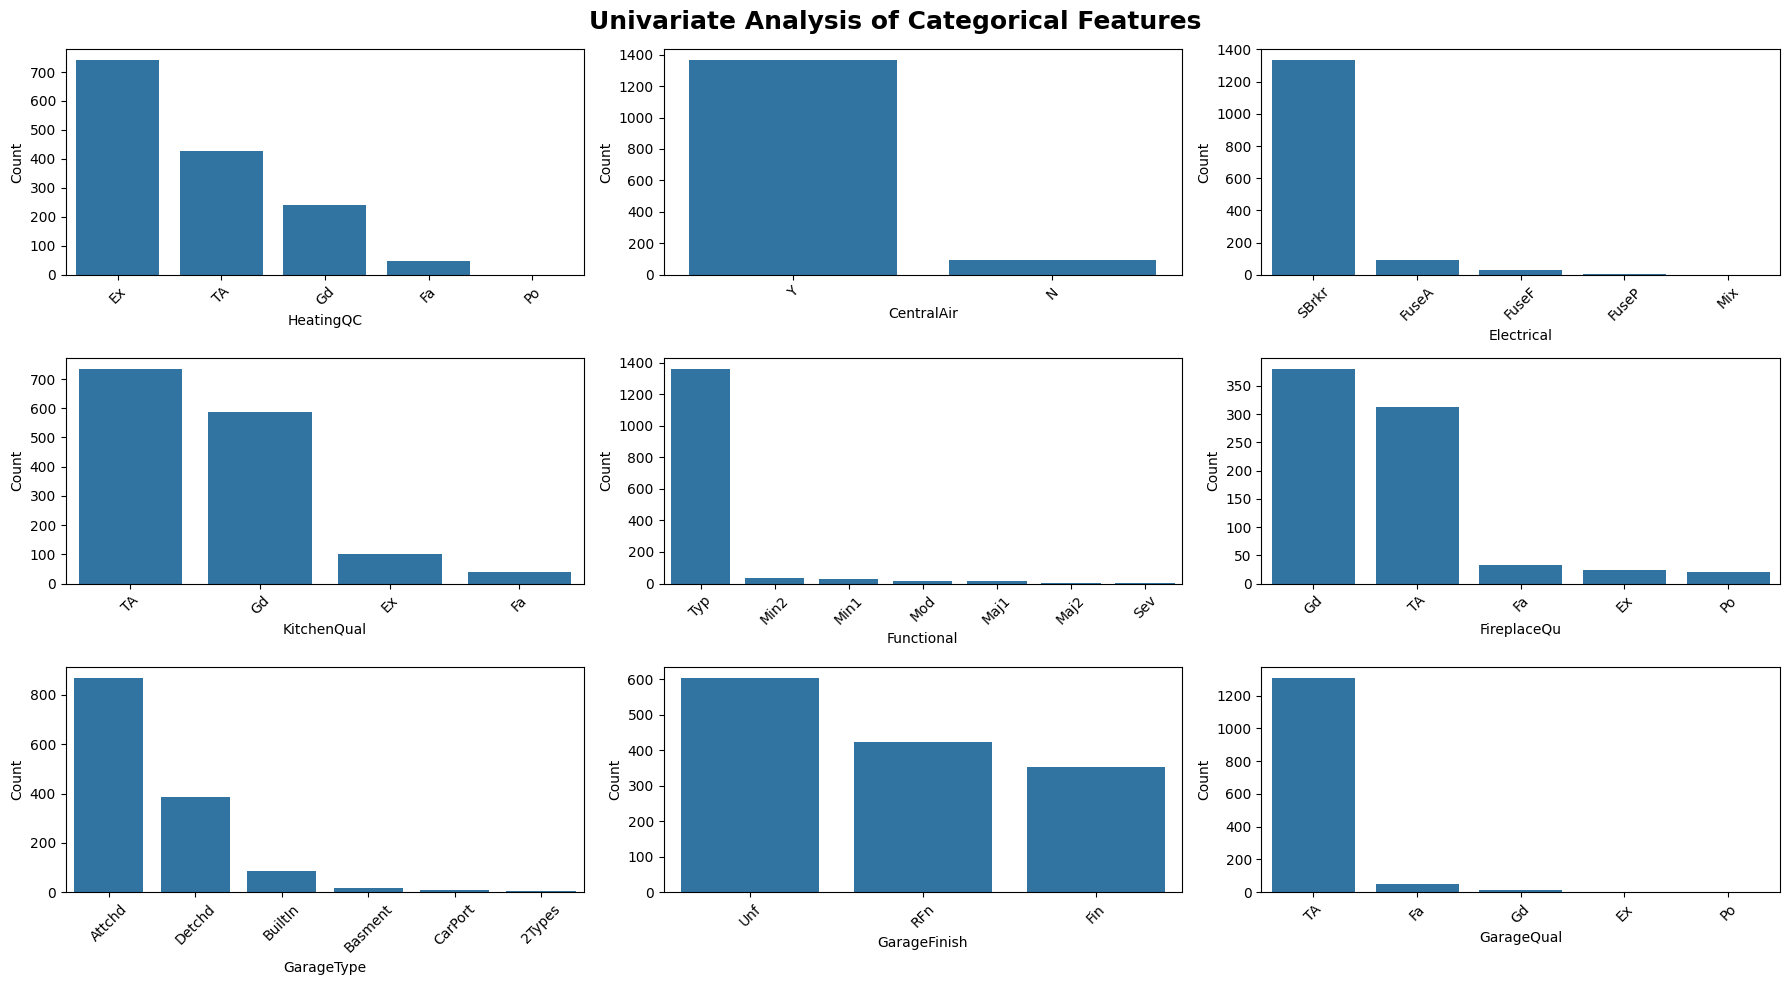

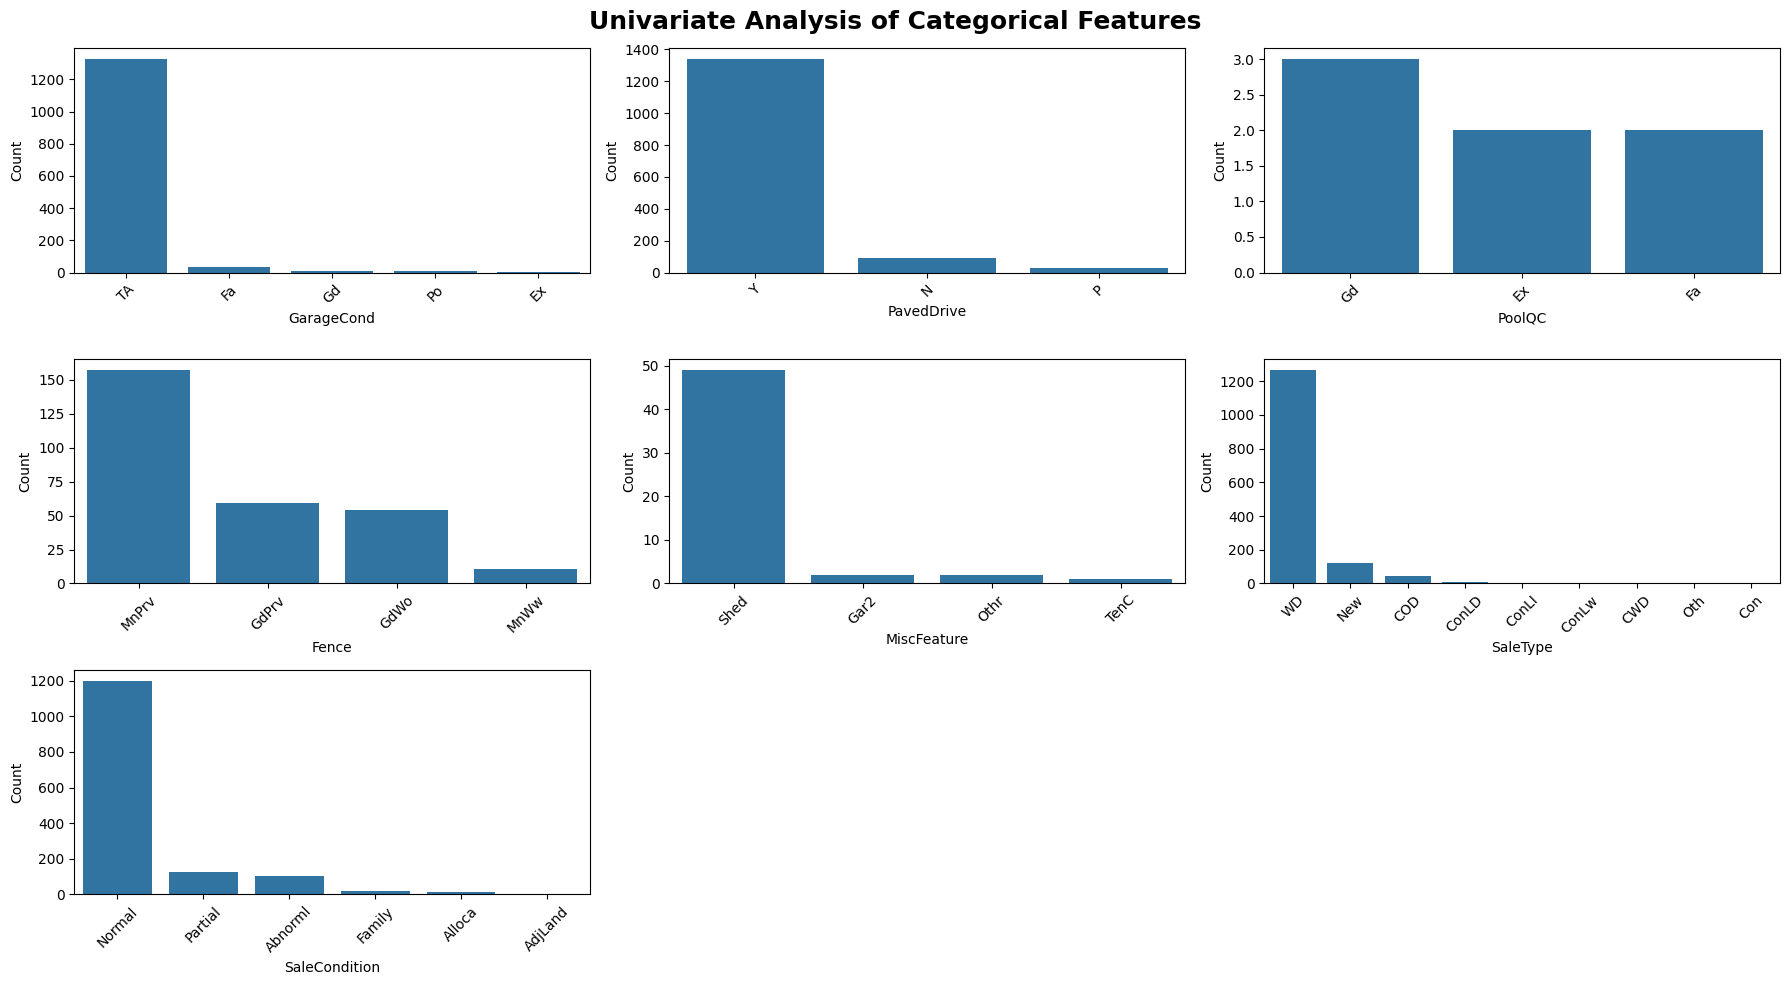

In [28]:
batch_size = 9  # 3x3 per figure

for i in range(0, len(categorical_features), batch_size):
    subset = categorical_features[i:i + batch_size]

    plt.figure(figsize=(18, 10))
    plt.suptitle(
        'Univariate Analysis of Categorical Features',
        fontsize=18,
        fontweight='bold'
    )

    for j, feature in enumerate(subset):
        plt.subplot(3, 3, j + 1)
        sns.countplot(
            x=kaggle_house_df[feature],
            order=kaggle_house_df[feature].value_counts().index
        )
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


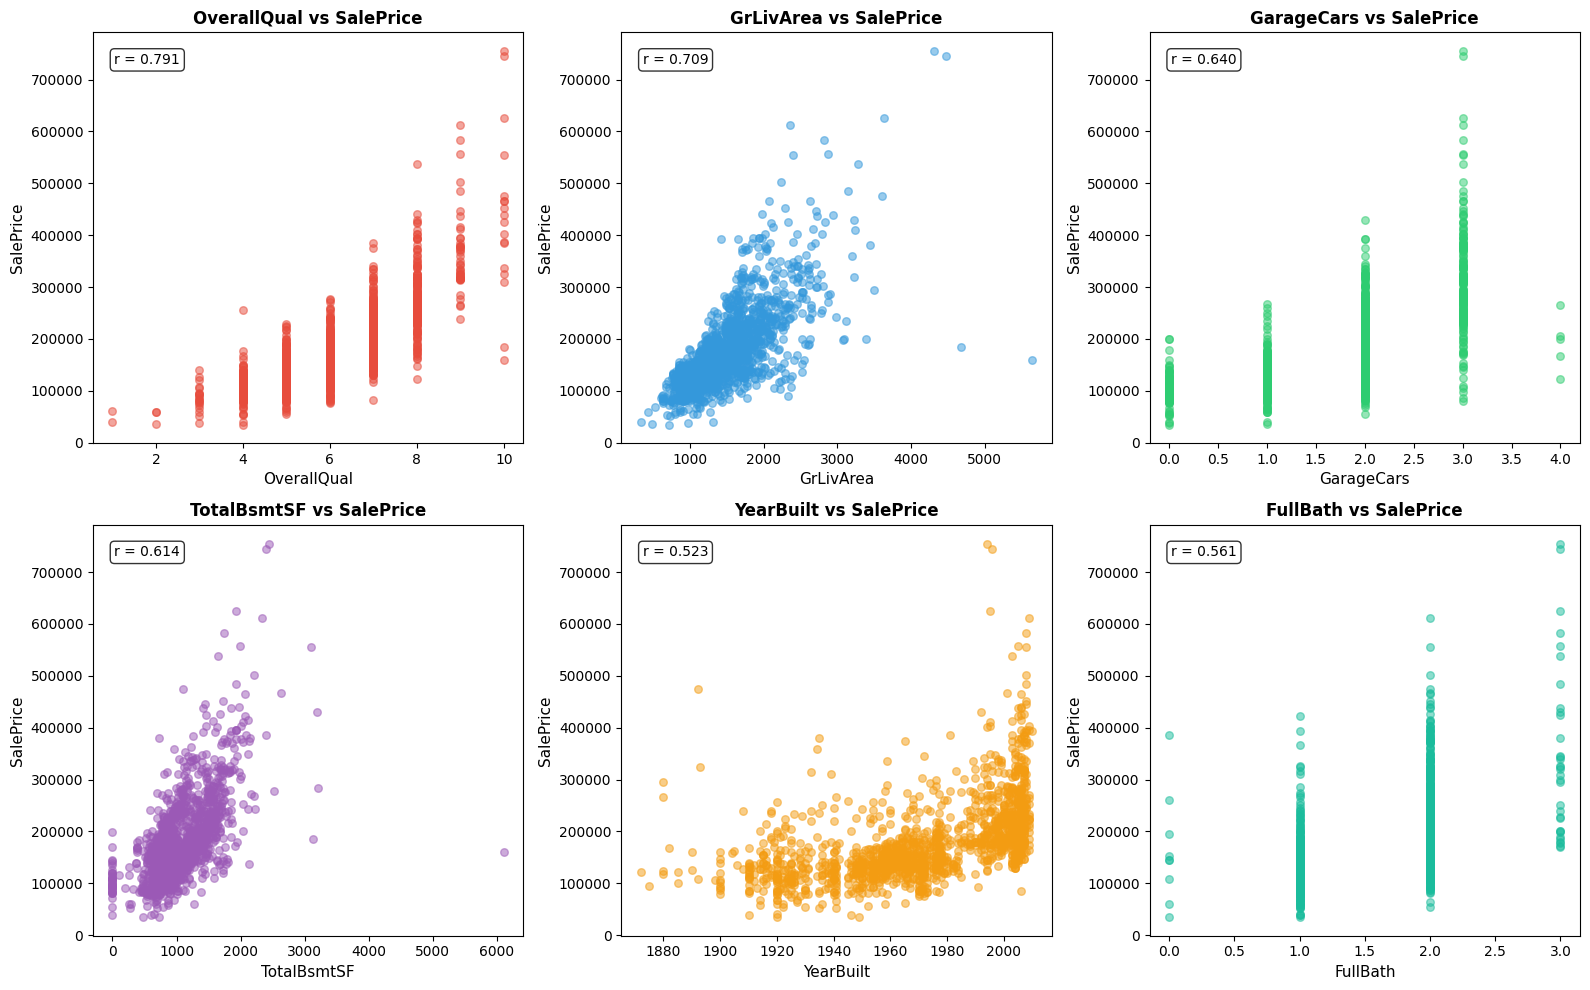

In [29]:
# Key features scatter plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'FullBath']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

for ax, feat, color in zip(axes.flatten(), features, colors):
    ax.scatter(kaggle_house_df[feat], kaggle_house_df['SalePrice'], alpha=0.5, c=color, s=30)
    ax.set_xlabel(feat, fontsize=11)
    ax.set_ylabel('SalePrice', fontsize=11)
    ax.set_title(f'{feat} vs SalePrice', fontsize=12, fontweight='bold')
    
    # Add correlation coefficient
    corr = kaggle_house_df[feat].corr(kaggle_house_df['SalePrice'])
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [30]:
discrete_features=[feature for feature in numeric_features if len(kaggle_house_df[feature].unique())<=25]

continuous_features=[feature for feature in numeric_features if len(kaggle_house_df[feature].unique()) > 25]

print('We have {} discrete features : {}'.format(len(discrete_features), discrete_features))
print('\nWe have {} continuous_features : {}'.format(len(continuous_features), continuous_features))

We have 18 discrete features : ['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

We have 19 continuous_features : ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'SalePrice']


In [31]:
for col, row in missing_df.iterrows():
    missing_count = row["Missing Count"]
    dtype = all_data[col].dtype

    print(f"{col}: {dtype}, Missing Count: {missing_count}")
    

PoolQC: str, Missing Count: 2909.0
MiscFeature: str, Missing Count: 2814.0
Alley: str, Missing Count: 2721.0
Fence: str, Missing Count: 2348.0
MasVnrType: str, Missing Count: 1766.0
FireplaceQu: str, Missing Count: 1420.0
LotFrontage: float64, Missing Count: 486.0
GarageQual: str, Missing Count: 159.0
GarageYrBlt: float64, Missing Count: 159.0
GarageCond: str, Missing Count: 159.0
GarageFinish: str, Missing Count: 159.0
GarageType: str, Missing Count: 157.0
BsmtExposure: str, Missing Count: 82.0
BsmtCond: str, Missing Count: 82.0
BsmtQual: str, Missing Count: 81.0
BsmtFinType2: str, Missing Count: 80.0
BsmtFinType1: str, Missing Count: 79.0
MasVnrArea: float64, Missing Count: 23.0
MSZoning: str, Missing Count: 4.0
BsmtFullBath: float64, Missing Count: 2.0
Functional: str, Missing Count: 2.0
BsmtHalfBath: float64, Missing Count: 2.0
Utilities: str, Missing Count: 2.0
BsmtFinSF1: float64, Missing Count: 1.0
Exterior2nd: str, Missing Count: 1.0
Exterior1st: str, Missing Count: 1.0
Electri

In [32]:
all_data["GarageYrBlt"].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933., 1917.,
       1896., 1895., 2207., 1943., 1919.])

# Feature Engineering

In [33]:
# Impute missing values
print('🔧 Imputing missing values...')

# Features where NA means "None" (no feature present)
none_features = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]
for col in none_features:
    all_data[col] = all_data[col].fillna('None')

# Features where NA means 0
zero_features = [
    'GarageYrBlt', 'GarageArea', 'GarageCars',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]
for col in zero_features:
    all_data[col] = all_data[col].fillna(0)

# LotFrontage - impute by neighborhood median
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)
# Mode imputation for remaining
mode_features = ['MSZoning', 'Electrical', 'KitchenQual', 
                 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']
for col in mode_features:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Drop Utilities (almost all same value)
all_data = all_data.drop('Utilities', axis=1)

# Convert MSSubClass to string (it's categorical)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

remaining_missing = all_data.isnull().sum().sum()
print(f'✓ Missing values remaining: {remaining_missing}')

🔧 Imputing missing values...
✓ Missing values remaining: 0


In [34]:
# Fix error of 2207 year entry to 2007
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].replace(2207, 2007)

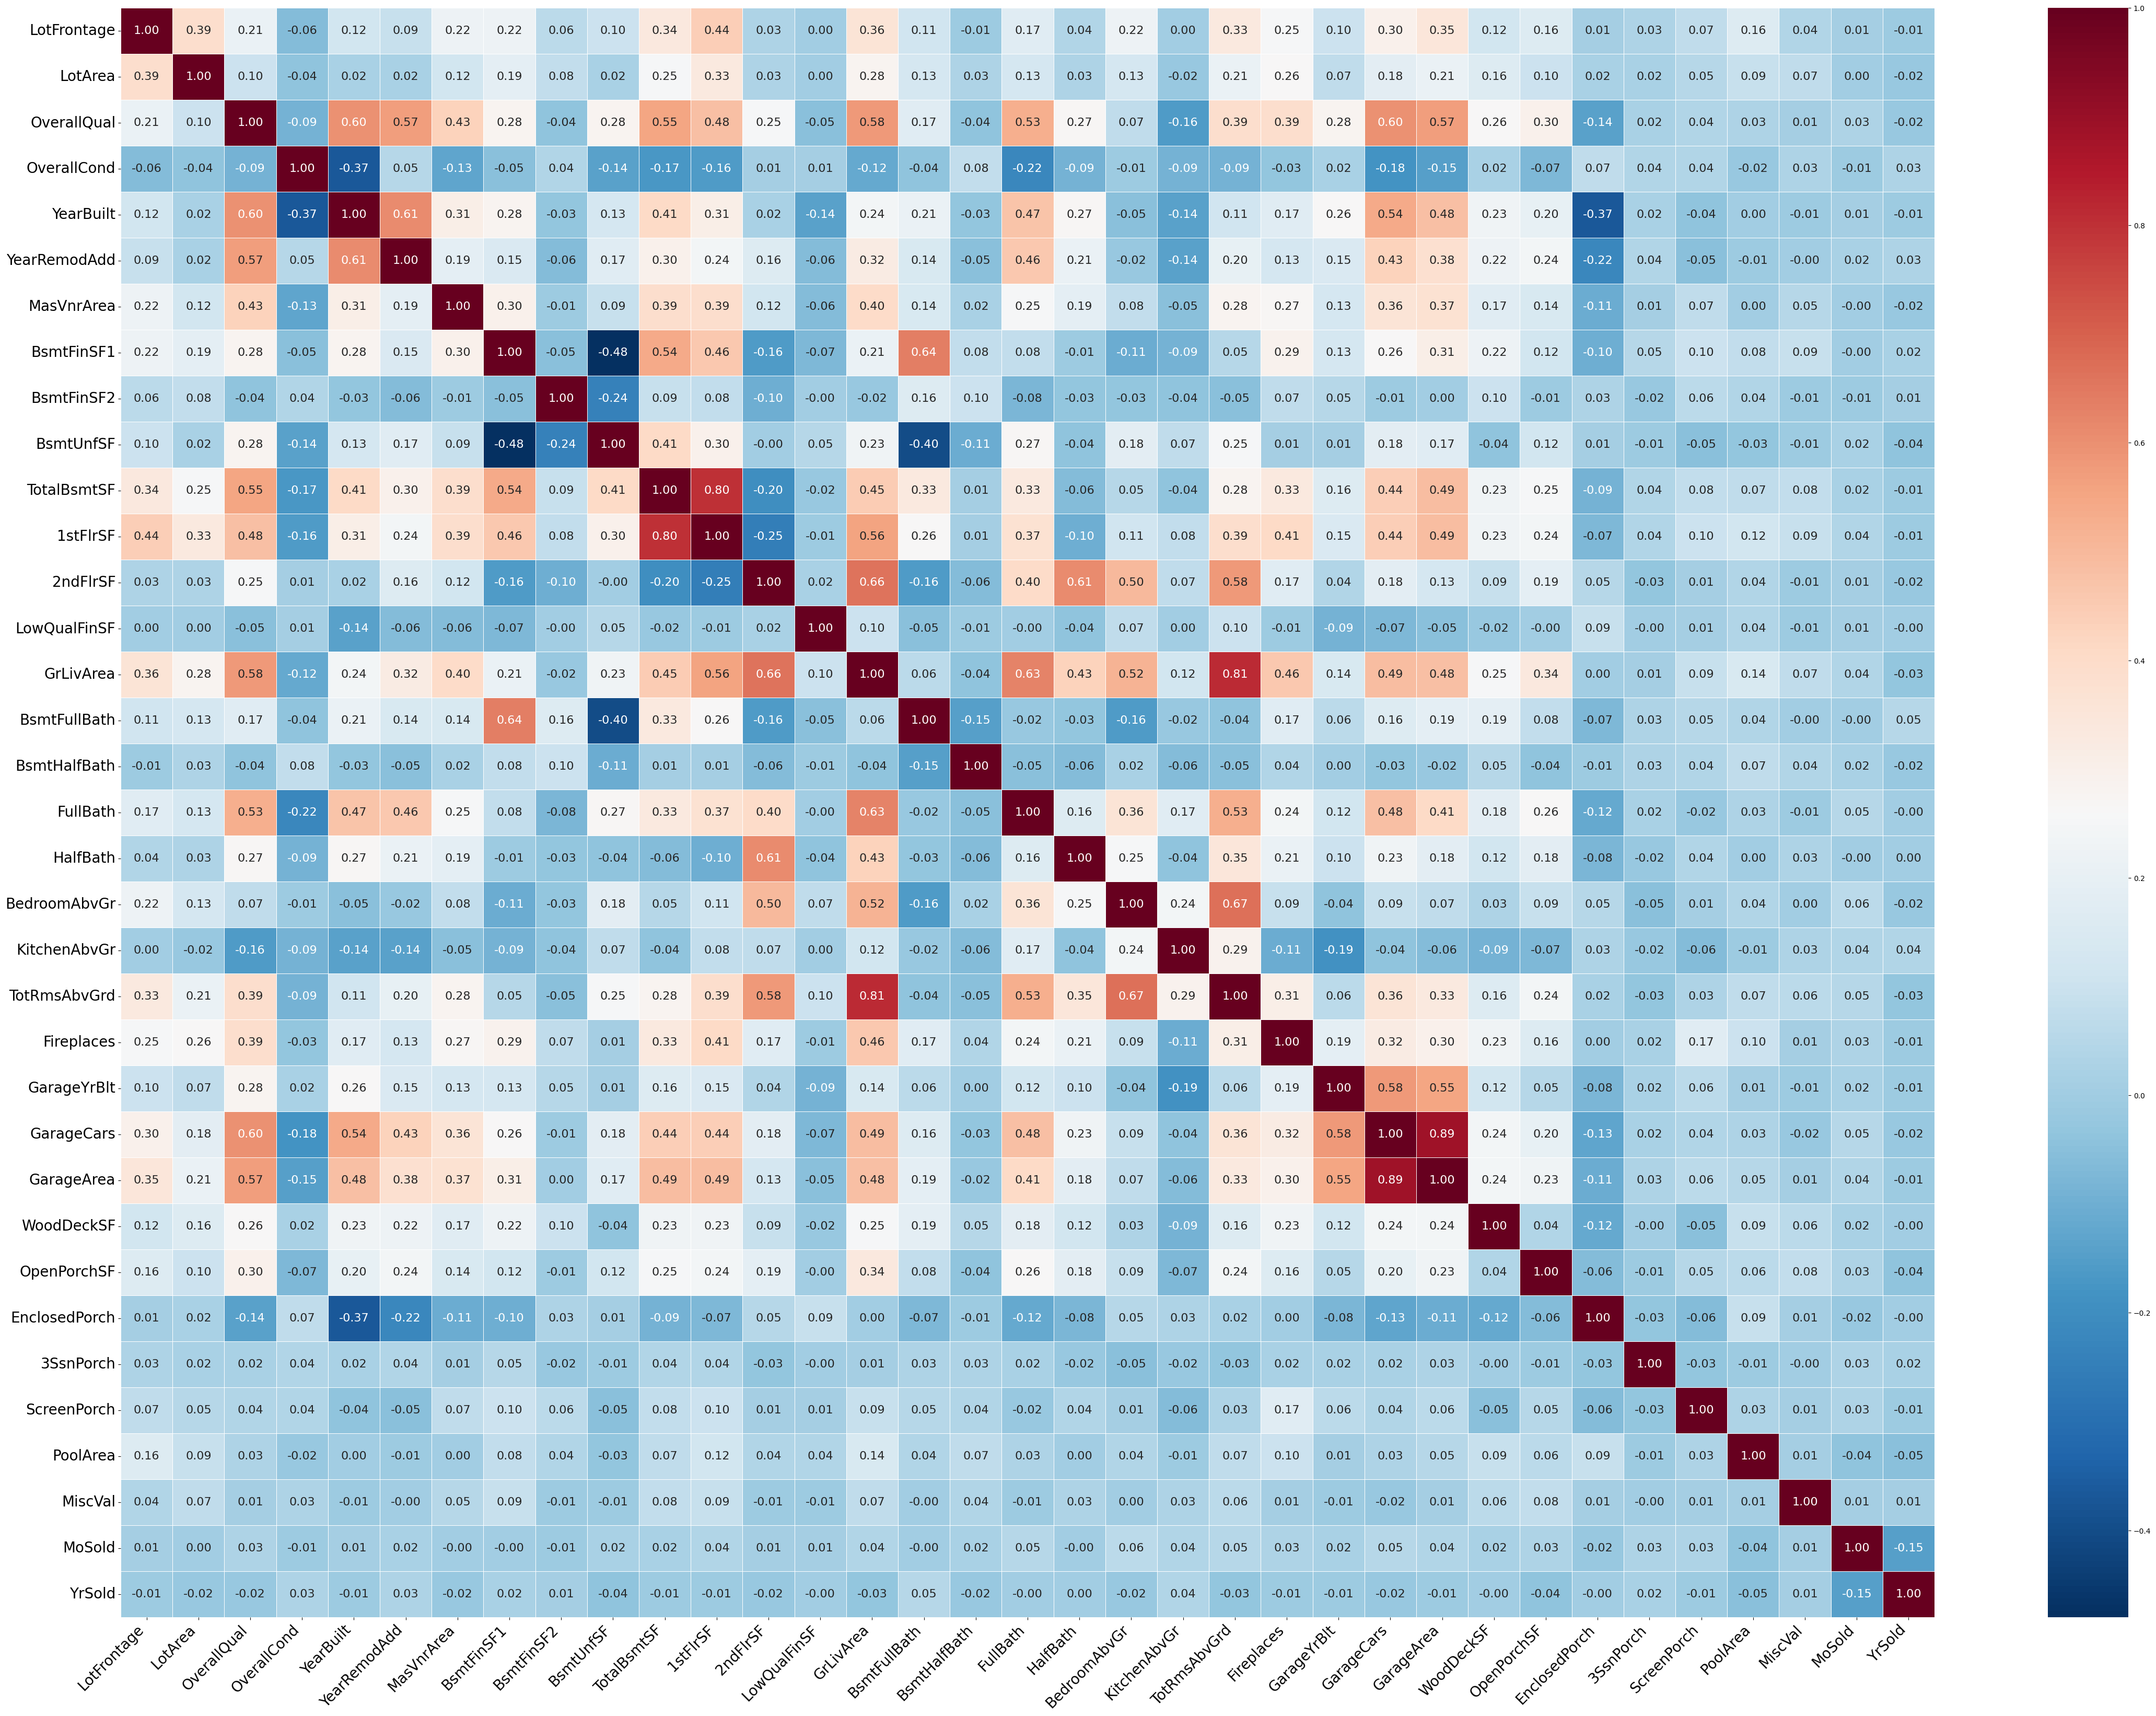

In [35]:
# Look up correlation between numeric features

# Select only numeric columns for calculating the correlation matrix
numeric_df = all_data.select_dtypes(include='number')

# Calculate the correlation matrix
df_corr = numeric_df.corr().round(2)

# Create a heatmap
plt.figure(figsize=(56, 40))
ax = sns.heatmap(
    df_corr,
    annot=True,
    cmap="RdBu_r",
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 16}   # 🔹 numbers inside cells
)

# 🔹 axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20, rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)


plt.show()

In [36]:
(all_data['PoolQC'] != 'None').astype(int)

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
31      0
32      0
33      0
34      0
35      0
36      0
37      0
38      0
39      0
40      0
41      0
42      0
43      0
44      0
45      0
46      0
47      0
48      0
49      0
50      0
51      0
52      0
53      0
54      0
55      0
56      0
57      0
58      0
59      0
60      0
61      0
62      0
63      0
64      0
65      0
66      0
67      0
68      0
69      0
70      0
71      0
72      0
73      0
74      0
75      0
76      0
77      0
78      0
79      0
80      0
81      0
82      0
83      0
84      0
85      0
86      0
87      0
88      0
89      0
90      0
91      0
92      0
93      0
94      0
95      0
96      0
97      0
98      0
99      0


In [37]:
# Create new meaningful features
print('🔧 Creating new features...')

# Total square footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Total bathrooms
all_data['TotalBath'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] + 
                         all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])

# Total porch area
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + 
                            all_data['3SsnPorch'] + all_data['ScreenPorch'])

# Binary features
all_data['HasPool'] = (all_data['PoolQC'] != 'None').astype(int)
all_data['HasGarage'] = (all_data['GarageType'] != 'None').astype(int)
all_data['HasBsmt'] = (all_data['BsmtQual'] != 'None').astype(int)
all_data['HasFireplace'] = (all_data['FireplaceQu'] != 'None').astype(int)
all_data['Remodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype(int)

# Age features
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']

print(f'✓ New features created')
print(f'✓ Total features: {all_data.shape[1]}')

🔧 Creating new features...
✓ New features created
✓ Total features: 88


In [38]:
# Log transform the target variable
y_train_log = np.log1p(y_train)

print('📊 Target transformation:')
print(f'   Original skewness: {skew(y_train):.4f}')
print(f'   Log-transformed skewness: {skew(y_train_log):.4f}')

# Fix skewness in numerical features
numeric_features = all_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f != 'Id']

skewed_features = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.75]

print(f'\n📊 Features with high skewness (|skew| > 0.75): {len(high_skew)}')

# Apply Box-Cox transformation
lam = 0.15
for feat in high_skew.index:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print('✓ Box-Cox transformation applied')

📊 Target transformation:
   Original skewness: 1.8809
   Log-transformed skewness: 0.1212

📊 Features with high skewness (|skew| > 0.75): 27
✓ Box-Cox transformation applied


In [39]:
# y_train_transformed = np.log1p(y_train)

# print("Target skewness:")
# print(f"Original : {skew(y_train):.3f}")
# print(f"Log1p    : {skew(y_train_transformed):.3f}")

# num_cols = all_data.select_dtypes(include=np.number).columns.tolist()
# num_cols = [c for c in num_cols if c.lower() != 'id']

# continuous_cols = [
#     c for c in num_cols
#     if all_data[c].nunique() > 10
# ]

# skew_df = (
#     all_data[continuous_cols]
#     .apply(lambda x: skew(x.dropna()))
#     .abs()
#     .sort_values(ascending=False)
# )

# skewed_cols = skew_df[skew_df > 0.8].index.tolist()

# print(f"Highly skewed continuous features: {len(skewed_cols)}")


# for col in skewed_cols:
#     if (all_data[col] <= 0).any():
#         # Handles zero / negative values
#         pt = PowerTransformer(method='yeo-johnson', standardize=False)
#         all_data[[col]] = pt.fit_transform(all_data[[col]])
#     else:
#         # Strictly positive values
#         all_data[col] = np.log1p(all_data[col])

# new_skew = all_data[skewed_cols].apply(lambda x: skew(x.dropna()))
# print("Max skew after transform:", new_skew.abs().max())

In [40]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,TotalSF,TotalBath,TotalPorchSF,HasPool,HasGarage,HasBsmt,HasFireplace,Remodeled,HouseAge,RemodAge
0,60,RL,5.831328,19.212182,Pave,None,Reg,Lvl,Inside,Gtl,...,14.976591,3.5,5.714669,0.0,0.730463,0.730463,0,0,5,5
1,20,RL,6.221214,19.712205,Pave,None,Reg,Lvl,FR2,Gtl,...,14.923100,2.5,0.000000,0.0,0.730463,0.730463,1,0,31,31
2,60,RL,5.914940,20.347241,Pave,None,IR1,Lvl,Inside,Gtl,...,15.149678,3.5,5.053371,0.0,0.730463,0.730463,1,1,7,6
3,70,RL,5.684507,19.691553,Pave,None,IR1,Lvl,Corner,Gtl,...,14.857121,2.0,9.080098,0.0,0.730463,0.730463,1,1,91,36
4,60,RL,6.314735,21.325160,Pave,None,IR1,Lvl,FR2,Gtl,...,15.852312,3.5,6.314735,0.0,0.730463,0.730463,1,0,8,8


In [41]:
# One-hot encode categorical variables
print('🔧 Encoding categorical variables...')

all_data = pd.get_dummies(all_data)
print(f'✓ Shape after encoding: {all_data.shape}')

# Split back to train and test
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]

print(f'\n📊 Final shapes:')
print(f'   X_train: {X_train.shape}')
print(f'   X_test: {X_test.shape}')
print(f'   y_train: {y_train_log.shape}')

🔧 Encoding categorical variables...
✓ Shape after encoding: (2919, 325)

📊 Final shapes:
   X_train: (1460, 325)
   X_test: (1459, 325)
   y_train: (1460,)


In [42]:

def rmse_cv_stratified(model, X, y, n_splits=5, bins=10):
    y_binned = pd.qcut(y, q=bins, duplicates='drop')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    rmse = np.sqrt(
        -cross_val_score(
            model, X, y,
            scoring='neg_mean_squared_error',
            cv=skf.split(X, y_binned)
        )
    )
    return rmse


In [43]:
def rmse_cv(model, X, y, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
    return rmse

print('✓ Cross-validation function ready')

✓ Cross-validation function ready


In [46]:
# Ridge
ridge = Pipeline([
    ('model', Ridge(alpha=10))
])
ridge_score = rmse_cv(ridge, X_train, y_train_log)
print(f'Ridge Regression:    RMSE = {ridge_score.mean():.4f} (+/- {ridge_score.std():.4f})')

# Lasso
lasso = Pipeline([
    ('model', Lasso(alpha=0.001, max_iter=10000))
])
lasso_score = rmse_cv(lasso, X_train, y_train_log)
print(f'Lasso Regression:    RMSE = {lasso_score.mean():.4f} (+/- {lasso_score.std():.4f})')

# ElasticNet
enet = Pipeline([
    ('model', ElasticNet(alpha=0.001, l1_ratio=0.9, max_iter=10000))
])
enet_score = rmse_cv(enet, X_train, y_train_log)
print(f'ElasticNet:          RMSE = {enet_score.mean():.4f} (+/- {enet_score.std():.4f})')

Ridge Regression:    RMSE = 0.1317 (+/- 0.0235)
Lasso Regression:    RMSE = 0.1301 (+/- 0.0245)
ElasticNet:          RMSE = 0.1295 (+/- 0.0245)


In [52]:
# XGBoost
print('📊 Evaluating gradient boosting models...\n')

model_xgb = xgb.XGBRegressor(
    n_estimators=900,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42,
    n_jobs=-1
)
xgb_score = rmse_cv(model_xgb, X_train, y_train_log, n_folds=3)
print(f'XGBoost:             RMSE = {xgb_score.mean():.4f} (+/- {xgb_score.std():.4f})')

# LightGBM
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=5,
    max_bin=55,
    bagging_fraction=0.8,
    bagging_freq=5,
    feature_fraction=0.5,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)
lgb_score = rmse_cv(model_lgb, X_train, y_train_log, n_folds=3)
print(f'LightGBM:            RMSE = {lgb_score.mean():.4f} (+/- {lgb_score.std():.4f})')

📊 Evaluating gradient boosting models...

XGBoost:             RMSE = 0.1270 (+/- 0.0151)
LightGBM:            RMSE = 0.1309 (+/- 0.0141)


In [58]:
# Optuna hyperparameter optimization
print('🔍 Running Optuna optimization...\n')

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',900, 2500),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.7),
        'gamma': trial.suggest_float('gamma', 0, 0.1),
    }
    
    model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
    score = rmse_cv(model, X_train, y_train_log, n_folds=3).mean()
    return score

# Create and run study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, show_progress_bar=True)

print(f'\n✓ Best RMSE: {study.best_value:.4f}')
print(f'\n📊 Best Parameters:')


🔍 Running Optuna optimization...



Best trial: 13. Best value: 0.126892: 100%|██████████| 15/15 [00:46<00:00,  3.08s/it]


✓ Best RMSE: 0.1269

📊 Best Parameters:


In [59]:
# Train final models
print('🚀 Training final models...\n')

# XGBoost with best parameters
best_params = study.best_params
final_xgb = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
final_xgb.fit(X_train, y_train_log)
print('✓ XGBoost trained')

🚀 Training final models...

✓ XGBoost trained


In [60]:
# Generate predictions
print('🔮 Generating predictions...\n')

pred_xgb = np.expm1(final_xgb.predict(X_test))

🔮 Generating predictions...



In [62]:
# Visualize predictions distribution
fig = px.histogram(
    pred_xgb, 
    nbins=50,
    title='Distribution of Predicted House Prices',
    labels={'value': 'Predicted SalePrice ($)', 'count': 'Frequency'},
    color_discrete_sequence=["#fc4204"]
)
fig.update_layout(showlegend=False)
fig.show()
fig.show(renderer='iframe')